In [76]:
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import h5py
import torch

from juart.conopt.functional.fourier import (
    fourier_transform_adjoint,
    fourier_transform_forward,
    nonuniform_fourier_transform_adjoint,
)
from juart.conopt.linops.identity import IdentityOperator
from juart.conopt.linops.tf import TransferFunctionOperator
from juart.conopt.proxalgs.cg import conjugate_gradient
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.vis.interactive import InteractiveFigure3D

In [23]:
matrix = [64, 64, 64]

In [24]:
data_path = "3DLiss_vd_preproc.h5"
with h5py.File(data_path, "r") as f:
    print(f"Dataset holds following data: {f.keys()}")

    print(f"Coilsensitivity info: {f['coilsens'].attrs['info']}")
    print(f"Trajectory info: {f['k'].attrs['info']}")
    print(f"Signal info: {f['d'].attrs['info']}")

    shape = (156, 156, 156, 2)
    ktraj = torch.from_numpy(f["k"][:])
    coilsens = torch.from_numpy(f["coilsens"][:])
    d = torch.from_numpy(f["d"][:])

    print(f"Coilsensitivity shape {coilsens.shape}")
    print(f"Trajectory shape {ktraj.shape}")
    print(f"Signal shape {d.shape}")

Dataset holds following data: <KeysViewHDF5 ['coilsens', 'd', 'k']>
Coilsensitivity info: Shape (Channels, Nx, Ny, Nz).
Trajectory info: Shape (Dimensions, Samples, Echotimes). Scaled in units of cycle/fov
Signal info: Shape (Channels, Samples, Echotimes).
Coilsensitivity shape torch.Size([8, 156, 156, 156])
Trajectory shape torch.Size([3, 2001191, 2])
Signal shape torch.Size([8, 2001191, 2])


In [25]:
nX, nY, nZ, nTI, nTE = 64, 64, 64, 2, 1
shape = (nX, nY, nZ, nTI, nTE)

mask = torch.linalg.norm(ktraj, dim=0) <= nX // 2

ktraj = torch.stack(
    [ktraj[:, mask[:, echo], echo] for echo in range(ktraj.shape[2])], dim=-1
)

d = torch.stack([d[:, mask[:, echo], echo] for echo in range(d.shape[2])], dim=-1)

coilsens_ksp = fourier_transform_forward(coilsens, axes=(1, 2, 3))
low_lim, up_lim = int(156 / 2 - nX / 2), int(156 / 2 + nX / 2)
coilsens_ksp = coilsens_ksp[:, low_lim:up_lim, low_lim:up_lim, low_lim:up_lim]
coilsens = fourier_transform_adjoint(coilsens_ksp, axes=(1, 2, 3))

In [91]:
k = ktraj / (2 * ktraj.max())

In [92]:
transfer_function = nonuniform_transfer_function(
    k[:, :, 0], data_shape=(1, matrix[0], matrix[1], matrix[2])
)


regridded_data = nonuniform_fourier_transform_adjoint(
    k[:, :, 0],
    d[:, :, 0],
    n_modes=tuple(matrix),
    modeord=0,
)

transfer_function_operator = TransferFunctionOperator(
    transfer_function, regridded_data.shape, axes=(1, 2, 3)
)

ident_operator = IdentityOperator(
    regridded_data.shape,
)

residual = []

In [108]:
# Calculate CG-NUFFT solution with regularization
d_vec = regridded_data.view(torch.float32).ravel()
init_guess = torch.zeros_like(d_vec, dtype=torch.float32)
ATA = transfer_function_operator

img, residual = conjugate_gradient(
    A=ATA, b=d_vec, x=init_guess, residual=residual, maxiter=40, verbose=True
)

img = img.view(torch.complex64).reshape(regridded_data.shape)
# img /= torch.max(torch.abs(img))

[CG] Iter: 39 Res: 1.47E-03 : 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


In [109]:
img_sos = torch.sum(torch.abs(img) ** 2, dim=0)

interactive(children=(IntSlider(value=32, description='Dimension 3', max=64, min=1), Output()), _dom_classes=(…

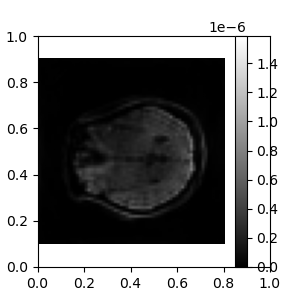

In [110]:
InteractiveFigure3D(
    torch.abs(img_sos[...]).numpy(),
    vmin=0,
    vmax=img_sos.abs().max(),
    cmap="gray",
).interactive